# 🦗 **Insect Classification Using Deep Learning**

### **Project Overview:**

In this project, we develop a deep learning model to classify insect species based on images. The dataset consists of **63,364 insect specimens** from the **Natural History Museum, London**, focusing on **British carabid beetles**. The goal is to automate insect species identification using computer vision. 🌍🐞

### **Dataset:**

* **63,364 specimens** scanned from insect drawers.
* Images are labeled with **GBIF species IDs**.
* Each folder corresponds to a specific insect species ID, like `1035167`.

### **Model Choice:**

We use **ResNet-50** for this image classification task due to its high performance in recognizing complex patterns in images. 📸💻

### **Methodology:**

1. **Data Preprocessing**: Resize, normalize, and prepare images for input. 🖼️
2. **Training**: Use **cross-entropy loss** and **Adam optimizer** for efficient learning. 🔧
3. **Evaluation**: Track training and validation accuracy to avoid overfitting. 📈
4. **Inference**: Once trained, the model will predict the species of new insect images. 🧠🔍

### **Results:**

* Model performance will be evaluated using **accuracy** and **loss** metrics.
* Visualize the results to understand how well the model is performing over time. 📊

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import shutil
import random
from pathlib import Path

from tqdm import tqdm

## **Preparing Dataset**

In [2]:
original_dataset = "/kaggle/input/insect-identification-from-habitus-images/database"
output_dir = "/kaggle/working/data"
train_ratio = 0.8

for split in ["train", "val"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

### **Sample Images**

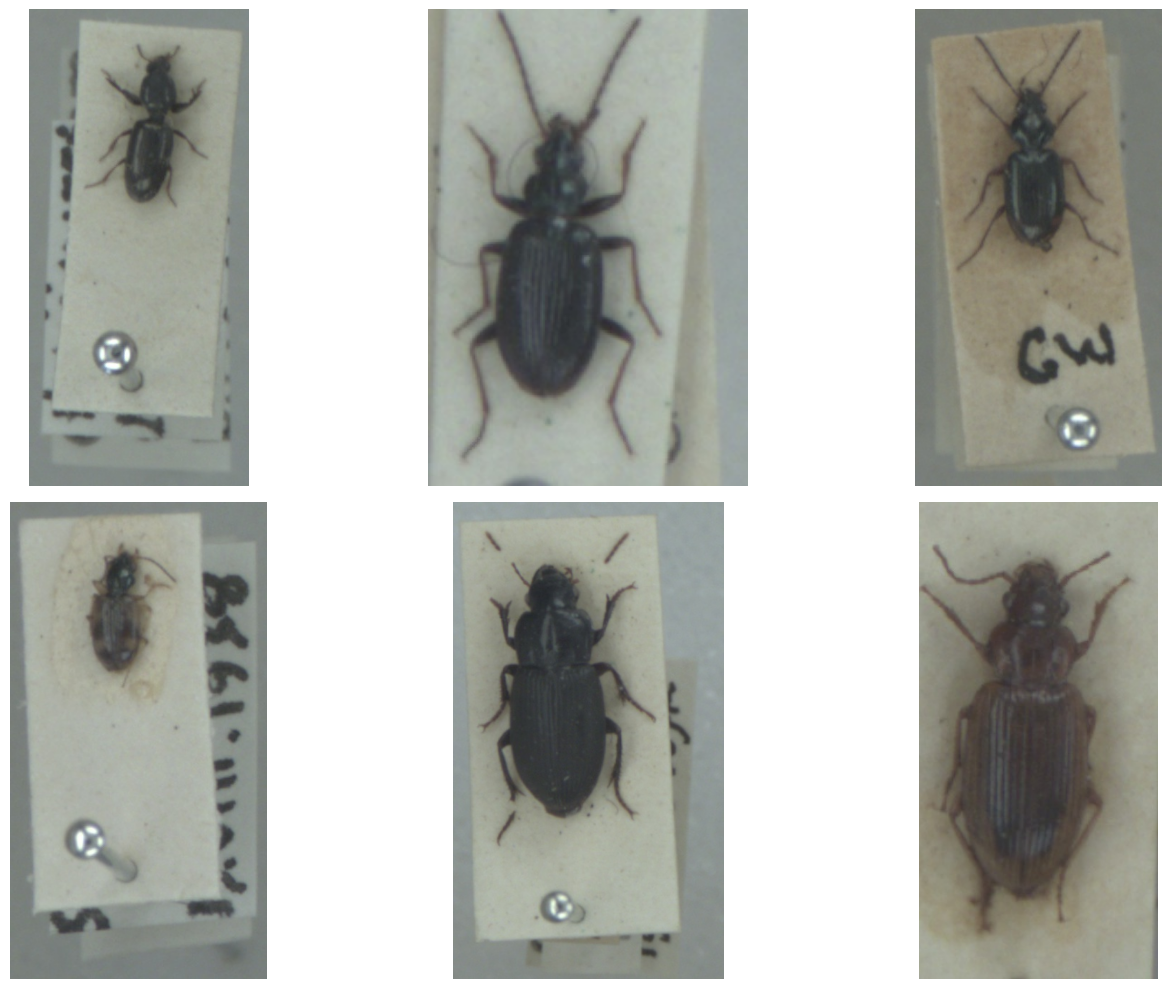

In [3]:
# List directories (subfolders) in the original dataset
folders = [f for f in os.listdir(original_dataset) if os.path.isdir(os.path.join(original_dataset, f))]

# Collect images from all directories
all_images = []
for folder in folders:
    folder_path = os.path.join(original_dataset, folder)
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    for image in images:
        all_images.append(os.path.join(folder_path, image))

# Shuffle the images randomly
random.shuffle(all_images)

# Select the first six shuffled images
selected_images = all_images[:6]

# Plot the images in a 2x3 grid (collage)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop through the axes and selected images to display
for ax, img_path in zip(axs.ravel(), selected_images):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Function Overview:

This below code splits images from an original dataset into training and validation sets, organizing them by species and saving them into corresponding directories.

### How it Works:

   * The function first lists all species folders in the original dataset using `os.listdir()` and `os.path.isdir()`.
   * For each species folder, the images are shuffled randomly using `random.shuffle()`.
   * The images are then split into training and validation sets based on the provided `train_ratio`.
   * It iterates over the training and validation splits, creating the necessary subdirectories (`train` or `val`) inside the output directory.
   * The images are copied from the original dataset to the appropriate subdirectories using `shutil.copyfile()`. The `os.makedirs()` function ensures the destination directories are created if they don't already exist.
   * The image copying process is tracked using `tqdm` to display a progress bar for the copying task.

In [4]:
species_folders = [d for d in os.listdir(original_dataset) if os.path.isdir(os.path.join(original_dataset, d))]
all_tasks = []

# Build task list
for species_folder in species_folders:
    species_path = os.path.join(original_dataset, species_folder)
    images = os.listdir(species_path)
    random.shuffle(images)
    split_point = int(len(images) * train_ratio)
    train_imgs = images[:split_point]
    val_imgs = images[split_point:]

    for split_name, split_imgs in zip(["train", "val"], [train_imgs, val_imgs]):
        for img in split_imgs:
            src = os.path.join(species_path, img)
            dst = os.path.join(output_dir, split_name, species_folder, img)
            all_tasks.append((src, dst))

# Run unified tqdm over all copy tasks
for src, dst in tqdm(all_tasks, desc="Copying images"):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

print("✅ Done splitting into train and val!")

Copying images: 100%|██████████| 63364/63364 [04:27<00:00, 236.51it/s]

✅ Done splitting into train and val!


The transformation pipeline performs the following steps:

* **Resize**: Resizes the image to 224x224 pixels to match the input size expected by most pre-trained models.
* **ToTensor**: Converts the image to a PyTorch tensor, making it compatible with neural network processing.
* **Normalize**: Normalizes the image using the mean (\[0.485, 0.456, 0.406]) and standard deviation (\[0.229, 0.224, 0.225]) values from the ImageNet dataset, ensuring the image is on the same scale as the data the model was trained on.

This pipeline prepares the image for deep learning models by standardizing its size, format, and pixel values.


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [6]:
train_dir = "/kaggle/working/data/train"
val_dir = "/kaggle/working/data/val"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### **Setup model**
This code initializes a pre-trained **ResNet-50** model and modifies its final fully connected layer to match the number of species in the dataset.

* `models.resnet50(pretrained=True)`: Loads the ResNet-50 model with pre-trained weights, which were trained on the ImageNet dataset.
* `model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))`: Replaces the final fully connected layer (`fc`) with a new one. The new layer has the same number of input features (`model.fc.in_features`) but its output size is set to the number of species in the dataset (`len(train_dataset.classes)`).

This ensures that the model’s output layer corresponds to the number of classes (species) in our specific dataset, making it ready for classification tasks.


In [7]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))  # auto-detect number of species

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **Training**

This code performs training and validation of a model, with early stopping based on validation accuracy to prevent overfitting.

### Key Steps:

1. **Epoch Loop**:

   * The loop runs for a specified number of epochs (`num_epochs`). During each epoch, the model is trained and evaluated on validation data.

2. **Training**:

   * The model is set to training mode using `model.train()`.
   * For each batch in the `train_loader`, the model:

     * Computes the predictions and calculates the loss.
     * Performs backpropagation (`loss.backward()`) and updates the weights (`optimizer.step()`).
   * The average training loss for the epoch is computed and printed.

3. **Validation**:

   * The model is set to evaluation mode using `model.eval()`.
   * In this mode, the gradients are turned off (`torch.no_grad()`), and predictions are made for the validation data.
   * The average validation loss and accuracy are computed and printed.

4. **Early Stopping**:

   * The model's validation accuracy is monitored during each epoch.
   * If validation accuracy improves, the model is saved as the "best model" and `trigger_times` is reset.
   * If validation accuracy does not improve for `patience` epochs, early stopping is triggered, and training stops early.

### Key Features:

* **Training Loss**: Monitors the loss during training.
* **Validation Accuracy and Loss**: Measures the model's performance on the validation set.
* **Early Stopping**: Stops training early if there is no improvement in validation accuracy after a specified number of epochs (`patience`).
* **Model Saving**: The best model (with the highest validation accuracy) is saved during training.

This approach ensures that the model doesn’t overfit and only trains as long as necessary to achieve the best validation performance.


In [9]:
from tqdm import tqdm

best_val_acc = 0.0
patience = 3
trigger_times = 0
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    
    # Training
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    print(f"📉 Average training loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    val_bar = tqdm(val_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = correct / total
    print(f"✅ Validation accuracy: {val_acc:.4f}")
    print(f"📉 Average validation loss: {avg_val_loss:.4f}")

    # Store the average validation loss for this epoch
    val_losses.append(avg_val_loss)

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print(f"💾 New best model saved (val_acc: {val_acc:.4f})")
    else:
        trigger_times += 1
        print(f"⚠️ No improvement. Patience: {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("🛑 Early stopping activated.")
            break



🔁 Epoch 1/20


📉 Average training loss: 4.1082


✅ Validation accuracy: 0.2213
📉 Average validation loss: 3.0508
💾 New best model saved (val_acc: 0.2213)

🔁 Epoch 2/20


📉 Average training loss: 2.0234


✅ Validation accuracy: 0.5234
📉 Average validation loss: 1.6249
💾 New best model saved (val_acc: 0.5234)

🔁 Epoch 3/20


📉 Average training loss: 1.1755


✅ Validation accuracy: 0.6764
📉 Average validation loss: 1.0706
💾 New best model saved (val_acc: 0.6764)

🔁 Epoch 4/20


📉 Average training loss: 0.8293


✅ Validation accuracy: 0.6344
📉 Average validation loss: 1.3061
⚠️ No improvement. Patience: 1/3

🔁 Epoch 5/20


📉 Average training loss: 0.6367


✅ Validation accuracy: 0.7431
📉 Average validation loss: 0.8430
💾 New best model saved (val_acc: 0.7431)

🔁 Epoch 6/20


📉 Average training loss: 0.5290


✅ Validation accuracy: 0.6404
📉 Average validation loss: 1.3631
⚠️ No improvement. Patience: 1/3

🔁 Epoch 7/20


📉 Average training loss: 0.4423


✅ Validation accuracy: 0.8253
📉 Average validation loss: 0.5748
💾 New best model saved (val_acc: 0.8253)

🔁 Epoch 8/20


📉 Average training loss: 0.3815


✅ Validation accuracy: 0.7045
📉 Average validation loss: 1.0474
⚠️ No improvement. Patience: 1/3

🔁 Epoch 9/20


📉 Average training loss: 0.3332


✅ Validation accuracy: 0.8188
📉 Average validation loss: 0.6210
⚠️ No improvement. Patience: 2/3

🔁 Epoch 10/20


📉 Average training loss: 0.2929


✅ Validation accuracy: 0.8101
📉 Average validation loss: 0.6287
⚠️ No improvement. Patience: 3/3
🛑 Early stopping activated.


## **Model Performance**

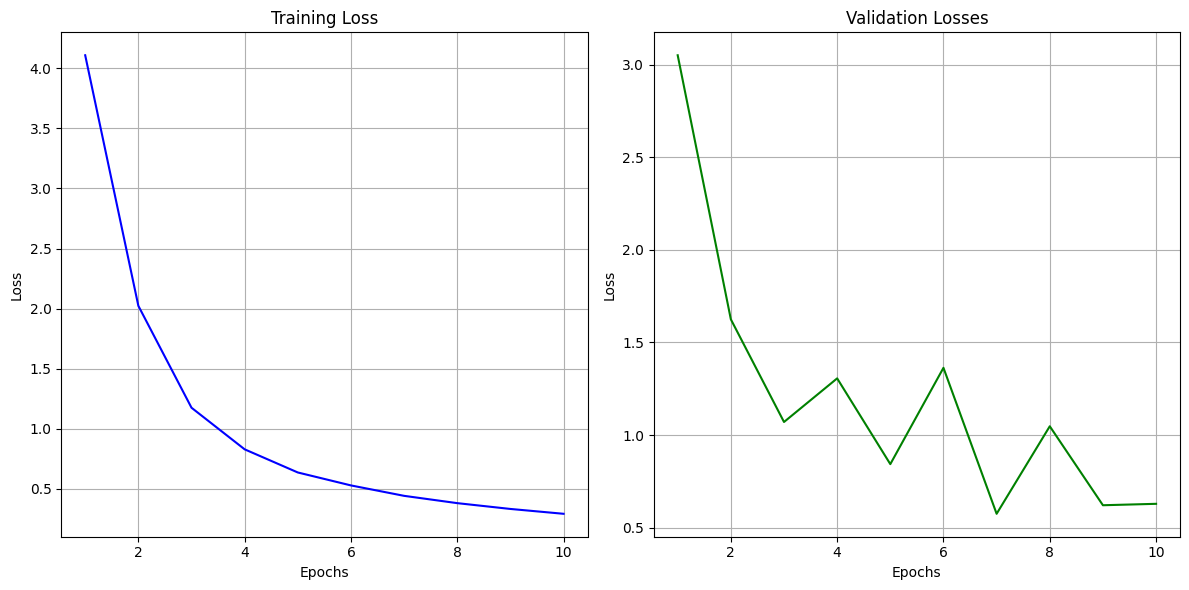

In [10]:
# Plotting the statistics
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color='blue')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Training Accuracy", color='green')
plt.title("Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


### **Reload best model**

In [11]:
# Reload your trained model (assuming saved as 'best_model.pth')
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model = model.to(device)

model.eval()  # Set model to evaluation mode

/tmp/ipykernel_18/1051267173.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## **Inferencing**

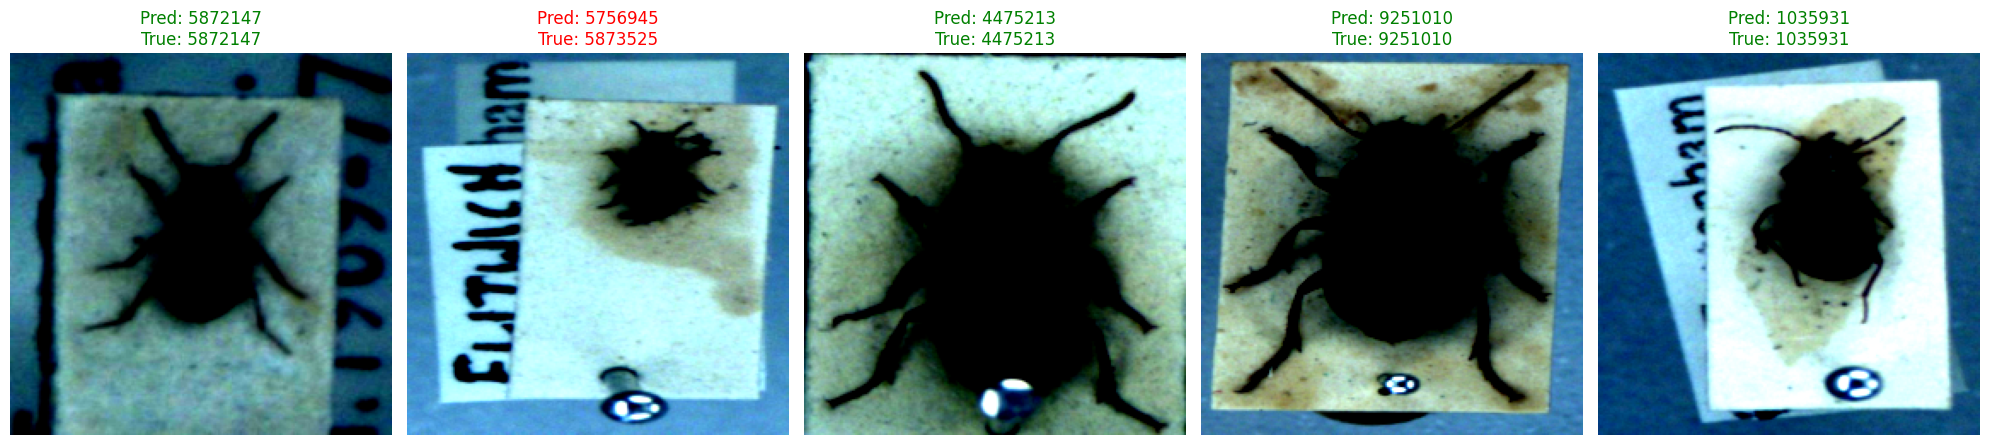

In [12]:
import os
import random
import torch
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Load validation dataset
val_dataset = datasets.ImageFolder("/kaggle/working/data/val", transform=transform)
class_labels = val_dataset.classes  # GBIF ID folder names

# Select 5 random images
random_indices = random.sample(range(len(val_dataset)), 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    image, true_label_idx = val_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
    _, pred_idx = torch.max(output, 1)

    predicted_label = class_labels[pred_idx.item()]
    true_label = class_labels[true_label_idx]

    # Color the title green if correct, red if wrong
    is_correct = predicted_label == true_label
    color = 'green' if is_correct else 'red'

    # Display image and result
    axes[i].imshow(image.permute(1, 2, 0).numpy())  # Convert CHW to HWC
    axes[i].set_title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
